In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
from qiskit.test.mock import FakeCasablanca
from mitiq import zne
import mitiq
from qiskit.providers.aer.extensions import SnapshotDensityMatrix
from mitiq.zne.scaling import fold_gates_from_left,fold_gates_at_random, fold_global,fold_gates_from_right
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyFactory
import qiskit.providers.aer.noise as noise
import ipyparallel as ipp
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit.quantum_info import Pauli
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from qiskit.circuit.random import random_circuit
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator,Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy

In [921]:
backend = FakeCasablanca() #Aer.get_backend('qasm_simulator')
def countYgates(pauli_label):
    countYgates = sum(map(lambda x : 1 if 'Y' in x else 0, pauli_label))
    return countYgates
def egBandHamiltonianPartition(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1_0=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1_1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                line=line.split()
                i,j=map(int,line[:2])
                val=float(line[2])
                if(i==j):
                    eg_h1_0[i,j]=eg_h1_0[i+num_sites,j+num_sites]=val
                else:
                    eg_h1_1[i,j]=eg_h1_1[i+num_sites,j+num_sites]=val
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1_0=eg_h1_0+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2_0=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        eg_h2_1=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            if((i==j) and (k==l)):
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k,l] = eg_h2_0[i,j,k+num_sites,l+num_sites] \
                = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
            else:
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
                eg_h2_1[i+num_sites,j+num_sites,k,l] = eg_h2_1[i,j,k+num_sites,l+num_sites] = 0.5*val
    return eg_h1_0,eg_h1_1,eg_h2_0,eg_h2_1
def Energy(params):
    circ=var_form_base.construct_circuit(parameters=params)
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    E=(state.conj()@Hmat@state).real
    return E
def qubitOp(h1,h2):  
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    qubit_conv = QubitConverter(ParityMapper(), two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
    #mapper=JordanWignerMapper()
    #qubit_op=mapper.map(fer_op)
    return qubit_op 
def LRF_2_body_OD_terms(h2): #For 2 body off-diagonal terms
    def reshape_vec_to_mat(eigs):
        weight,vec1,vec2=eigs
        num_qubits=int(numpy.sqrt(vec1.shape[0]))
        L1=numpy.reshape(vec1,(num_qubits,num_qubits))
        L2=numpy.reshape(vec2,(num_qubits,num_qubits))
        return [numpy.sqrt(numpy.complex(weight))*L1,numpy.sqrt(numpy.complex(weight))*L2]
    #checksum  
    def higherRankRep(L):
        T=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))*1j
        for p in range(num_qubits):
            for q in range(num_qubits):
                for r in range(num_qubits):
                    for s in range(num_qubits):
                        T[p,q,r,s]=L[p,q]*L[r,s]
                        
        return T
    def get_givens_rotns(L):
        num_qubits=len(L)
        qubitH=qubitOp(numpy.zeros((8,8)),h2_X)
        num_qubits_red=qubitH.num_qubits
        H=qubitH.to_matrix()
        givens=givensRotns(L)[0]
        rotH=qubitH
        #print(givens,rotH)
        Ops=['IIIIIY','IIYIII']
        circ=QuantumCircuit(num_qubits_red)
        for l in range(len(givens)):
            rots=givens[l]
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
                Op=PauliSumOp.from_list([('I'*num_qubits_red,1)])
                List=[(Ops[l],0.5)]
                for i in range(len(List)):
                    Op=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(theta*List[i][1])),(List[i][0],-1j*numpy.sin(theta*List[i][1]))])@Op
                    circ=add_multiqubit_gate(List[i][0], theta*List[i][1], circ)  
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
        return circ,rotH,qubitH
    #constructing Low rank factorization circuits
    #Super matrix rep of four rank tensor (NxNxNxN)->(N^2xN^2)
    num_qubits=len(h2)
    N2=num_qubits*num_qubits
    h2_pq_rs=numpy.reshape(h2,(N2,N2))
    #Diagonalize Super matrix
    #u,d,v=numpy.linalg.svd(h2_pq_rs,full_matrices=True)
    w,v=numpy.linalg.eigh(h2_pq_rs)
    #Build Cholesky vectors
    Larr=[]
    arr=[((w[i],v[:,i],v.conj().T[i])) for i in range(len(v)) if numpy.abs(w[i])>1e-4]
    Larr=list(map(reshape_vec_to_mat,arr))
    qc,rotH,qubit_h2=get_givens_rotns(Larr[0][0])
    return qc,rotH,qubit_h2

def add_multiqubit_gate(pauli_string, param, circuit):
    num_qubits=circuit.num_qubits
    qr=QuantumRegister(num_qubits,'q')
    if pauli_string == 'I'*num_qubits:
        gate = 1
        for j in range(len(pauli_string)):
            gate = numpy.kron(gate, Pauli('I').to_matrix())
        gate *= -1j * np.sin(param)
        gate += numpy.cos(param) * np.eye(2**num_qubits)
        circuit.unitary(gate, qr, label=pauli_string)
    else:
        qubits_to_act_on = []
        gate = 1
        for j in range(len(pauli_string)):
            if pauli_string[j] != 'I':
                gate=numpy.kron(Pauli(pauli_string[j]).to_matrix(),gate)
                qubits_to_act_on.append(num_qubits-j-1)
        gate *= (-1j * numpy.sin(param))
        gate += numpy.cos(param) * numpy.eye(2**len(qubits_to_act_on))
        List_regs=[qr[i] for i in qubits_to_act_on]#[::-1]
        Label=pauli_string+"\n{:0.02f}".format(param.real)
        circuit.unitary(gate, List_regs, label = Label)
    return circuit  

def get_givens_rotns(h):
        num_qubits=len(h)
        qubitH=qubitOp(h,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
        num_qubits_red=qubitH.num_qubits
        H=qubitH.to_matrix()
        w,v=numpy.linalg.eigh(h)
        givens=givensRotns(v.T)[0]
        rotH=qubitH
        circ=QuantumCircuit(num_qubits_red)
        for rots in givens:
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
                List=qubit_h1.primitive.to_list()
                Op=PauliSumOp.from_list([('I'*num_qubits_red,1)])
                for i in range(len(List)):
                    Op=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(theta*List[i][1])),(List[i][0],1j*numpy.sin(theta*List[i][1]))])@Op
                    circ=add_multiqubit_gate(List[i][0], theta*List[i][1], circ)
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
        return circ,rotH,qubitH
    
def doubly_decomposed_form(h1_D,h1_X,h2_D,h2_X):

    #getting the givens rotation circuit and the rotated Hamiltonian for the one body terms
    circ_1_body,rotH_1_X,qubitH_1_X=get_givens_rotns(h1_X)
    #getting Cholesky vectors for two body off-diag terms
    circ_2_body,rotH_2_X,qubitH_2_X=LRF_2_body_OD_terms(h2_X)
    qubitH_D=qubitOp(h1_D,h2_D)
    circs_and_rotH_arr=[(circ_1_body,rotH_1_X,qubitH_1_X),(circ_2_body,rotH_2_X,qubitH_2_X),(qubitH_D)]
    return circs_and_rotH_arr

def expectation(h,circ):
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    h_expec=state.conj()@h.to_matrix()@state
    return h_expec

def hamiltonian_estimation_in_doubly_decomposed_form_qasm(params,num_shots_arr=[2**18,2**18,2**18],measure_with_noise=False):
    def Energy_Estimator_DD(input_vars):
        def getCounts(Input,noise_model=None,basis_gates=None):
            circ,num_shots=Input
            circ1=circ.copy()
            circ1.add_register(ClassicalRegister(6,'c'))
            circ1.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
            job = execute(circ1, backend,shots=num_shots)#,basis_gates=basis_gates,noise_model=noise_model,had_transpiled=True) 
            res = job.result()
            counts = res.get_counts(circ1) 
            return counts
        def estimate(PauliOp,counts):
            PauliString,coeff=PauliOp.primitive.to_list()[0]
            indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
            bitstrings,cnts=list(counts. keys()),list(counts.values())
            p=0
            count_valid=0
            for i in range(len(bitstrings)):
                bit_Str_to_Arr=numpy.array(list(bitstrings[i]))
                #flag1=1 if len(numpy.where(bit_Str_to_Arr=='1')[0])==4 else 0 #check number of electrons
                #flag2=1 if len(numpy.where(bit_Str_to_Arr[0:4]=='1')[0])==2 else 0 #check net spin
                #if ((flag1==1) and (flag2==1)):
                #count_valid=count_valid+cnts[i]
                counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
                if counter_1%2==1:
                    p=p+cnts[i]
            p=p/sum(cnts)
            mean=(1-2*p)
            return mean*coeff.real
        def meanOp(PauliOp,counts):
            mean=0
            for i in range(len(PauliOp)):
                mean=mean+estimate(PauliOp[i],counts)
            return mean 
        def covariance(Op,i,j,counts):
            cov=estimate(Op[i]@Op[j],counts)-estimate(Op[i],counts)*estimate(Op[j],counts)
            return cov
        def covbtnOps(A,B,counts):
            corr=0
            for i in range(len(A)):
                for j in range(len(B)):
                    corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
            return corr        
        def variance(Op,counts):
            var=0
            cov_mat=numpy.zeros((len(Op),len(Op)))
            for i in range(len(Op)):
                for j in range(i,len(Op)):
                    if i==j:
                        mean=estimate(Op[i],counts)
                        coeff=Op[i].primitive.to_list()[0][1].real
                        cov_mat[i][j]=(coeff**2-mean**2)
                        var=var+(coeff**2-mean**2)
                    elif i!=j:
                        var=var+2*covariance(Op,i,j,counts)
                        cov_mat[i][j]=cov_mat[j][i]=covariance(Op,i,j,counts)
            return var
        def OpErr(data):
            Op,counts=data
            var=variance(Op,counts)
            err=numpy.sqrt(var/sum(counts.values()))
            return err.real
        if len(input_vars)==5:
            circ,Op,num_shots,noise_model,basis_gates=input_vars
            counts_Arr=getCounts((circ,num_shots),noise_model,basis_gates)
            m1=meanOp(Op,counts_Arr)
            err1=OpErr((Op,counts_Arr))
        else:
            circ,Op,num_shots=input_vars
            counts_Arr=getCounts((circ,num_shots))
            m1=meanOp(Op,counts_Arr)
            err1=OpErr((Op,counts_Arr))
        return m1,err1,counts_Arr
    #params,num_shots_arr=input_vars
    ansatz_circ=var_form_base.construct_circuit(params)
    circ_rot_Arr=[ansatz_circ.copy(),ansatz_circ.copy(),ansatz_circ.copy()]
    circ_rot_Arr[0]=circ_rot_Arr[0]+circs_and_rotH[0][0]
    circ_rot_Arr[1]=circ_rot_Arr[1]+circs_and_rotH[1][0]
    #Estimate from statistics
    data_arr=[(circ_rot_Arr[0],circs_and_rotH[0][1],num_shots_arr[0]),
              (circ_rot_Arr[1],circs_and_rotH[1][1],num_shots_arr[1]),
              (circ_rot_Arr[2],circs_and_rotH[2],num_shots_arr[2])]
    results=Parallel(n_jobs=1,verbose=2)(delayed(Energy_Estimator_DD)(data_arr[i]) for i in range(len(data_arr)))
    m1,err1,counts1=results[0][0],results[0][1],results[0][2]
    m2,err2,counts2=results[1][0],results[1][1],results[1][2]
    m3,err3,counts3=results[2][0],results[2][1],results[2][2]
    return m1+m2+m3,err1+err2+err3,[counts1,counts2,counts3]
def Energy(params):
    circ=var_form_base.construct_circuit(parameters=params)
    state=numpy.array(list(execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()))
    E=(state.conj()@Hmat@state).real
    return E

In [922]:
U=7
h1_D,h1_X,h2_D,h2_X=egBandHamiltonianPartition(U)
circs_and_rotH=doubly_decomposed_form(h1_D,h1_X,h2_D,h2_X)    
def qubitWeightedOp(h1,h2):
    qubit_op=FermionicOperator(h1,h2).mapping('parity')
    qubitH=Z2Symmetries.two_qubit_reduction(qubit_op, qubit_op.num_qubits//2)
    return qubitH
qubitH=qubitWeightedOp(h1_D+h1_X,h2_D+h2_X)
Hmat=op_converter.to_matrix_operator(qubitH).dense_matrix
w,v=numpy.linalg.eigh(Hmat)
Eg=w[0]
circ=QuantumCircuit(6)
circ.x(0)
circ.x(3)
var_form_base=UCCSD(8,num_particles=4, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
var_form_base.manage_hopping_operators()

In [746]:
with open('OptStepsWithqasm_parityU=7Fin.txt','r') as f:
    lines=f.readlines()
    Labels=[]
    for i in range(len(lines)):
        if lines[i][0]=='l':
            Labels.append(lines[i].split('-')[1][1:-1])
    params=eval(lines[-1])    
for i in range(len(Labels)):
    var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli(Labels[i])]]))   

In [747]:
h_N=numpy.eye(8)
h_Sz=numpy.block([[numpy.eye(4),numpy.zeros((4,4))],
                  [numpy.zeros((4,4)),-1*numpy.eye(4)]])

In [748]:
qubitN=qubitOp(h_N,numpy.zeros((8,8,8,8)))
N_matrix=qubitN.to_matrix()
qubitSz=qubitOp(h_Sz,numpy.zeros((8,8,8,8)))
Sz_matrix=qubitSz.to_matrix()

In [749]:
def NumParticlesBitstring(bit_str):
    state_vector=numpy.zeros(2**6)
    state_vector[int(bit_str,2)]=1
    return numpy.real(state_vector@N_matrix@state_vector.T)
def SpinBitstring(bit_str):
    state_vector=numpy.zeros(2**6)
    state_vector[int(bit_str,2)]=1
    return numpy.real(state_vector@Sz_matrix@state_vector.T)

In [237]:
Energy(params)

-19.184209626793663

In [9]:
m,err,counts=hamiltonian_estimation_in_doubly_decomposed_form_qasm(params,num_shots_arr=[2**14,2**14,2**14])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.7s finished


In [9]:
m,err

(-13.86870002797314, 0.05368579136990162)

In [750]:
def filter_bitstrings(counts):
    Keys=list(counts.keys())
    Vals=list(counts.values())
    newCounts={}
    for i in range(len(Keys)):
        n=NumParticlesBitstring(Keys[i])
        s=SpinBitstring(Keys[i])
        if (numpy.abs(n-4)<1e-3 and  numpy.abs(s)<1e-3):
            newCounts[Keys[i]]=Vals[i]
        else:
            continue
    return newCounts        

In [751]:
def confusion_matrix(num_qubits,noisy_backend,num_shots):
    num_qubits=6
    Dict_bitstr={}
    for i in range(2**num_qubits):
        qc=QuantumCircuit(num_qubits)
        bit_str=str(format(i,'b'))
        pos_Xs=numpy.where(numpy.array(list(bit_str)[::-1])=='1')[0]
        for ind in pos_Xs:
            qc.x(ind)
        qc=qiskit.transpile(qc,basis_gates=basis_gates,coupling_map=coupling_map)
        qc.add_register(ClassicalRegister(num_qubits,'c'))
        qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
        job = noisy_backend.run(qc, shots=num_shots)
        #job = execute(qc, noisy_backend,shots=num_shots)#,basis_gates=basis_gates,noise_model=noise_model,had_transpiled=True) 
        res = job.result()
        counts = res.get_counts(qc)     
        Dict_bitstr[bit_str]=counts
    M=numpy.zeros((2**num_qubits,2**num_qubits))
    for i in range(2**num_qubits):
        transfer_map=Dict_bitstr[str(format(i,'b'))]
        Keys=list(transfer_map.keys())
        Values=list(transfer_map.values())
        for j in range(len(Keys)):
            print(i,int(Keys[j],2),Values[j]/num_shots)
            M[i][int(Keys[j],2)]=Values[j]/num_shots
    return M

In [50]:
numpy.set_printoptions(precision=3,suppress=True)
noisy_backend=FakeCasablanca()
M=confusion_matrix(6,noisy_backend,2**14)

0 12 6.103515625e-05
0 48 6.103515625e-05
0 34 6.103515625e-05
0 9 0.00018310546875
0 33 6.103515625e-05
0 18 0.0001220703125
0 8 0.01336669921875
0 0 0.9442138671875
0 32 0.00750732421875
0 2 0.00677490234375
0 16 0.00714111328125
0 1 0.00726318359375
0 6 6.103515625e-05
0 40 0.0001220703125
0 4 0.01300048828125
1 35 6.103515625e-05
1 17 0.00634765625
1 0 0.03082275390625
1 7 6.103515625e-05
1 13 0.0001220703125
1 1 0.921875
1 9 0.012939453125
1 5 0.0118408203125
1 33 0.0069580078125
1 16 0.0003662109375
1 2 0.00042724609375
1 25 0.000244140625
1 37 6.103515625e-05
1 41 6.103515625e-05
1 8 0.00067138671875
1 3 0.00677490234375
1 4 0.000244140625
1 32 0.0001220703125
2 10 0.01409912109375
2 42 6.103515625e-05
2 11 6.103515625e-05
2 0 0.0181884765625
2 7 0.0001220703125
2 2 0.93292236328125
2 16 0.0003662109375
2 6 0.01318359375
2 3 0.007080078125
2 4 0.0003662109375
2 19 6.103515625e-05
2 34 0.0064697265625
2 18 0.0064697265625
2 8 0.00018310546875
2 26 6.103515625e-05
2 1 0.0001220703

24 8 0.02227783203125
24 18 0.0001220703125
24 58 6.103515625e-05
24 56 0.0068359375
24 40 0.0001220703125
24 24 0.9276123046875
24 25 0.00555419921875
24 17 6.103515625e-05
24 10 0.00018310546875
24 26 0.00726318359375
24 48 0.00018310546875
24 20 0.0001220703125
24 29 0.0001220703125
24 9 0.0001220703125
24 60 0.0001220703125
25 26 0.0001220703125
25 19 6.103515625e-05
25 0 6.103515625e-05
25 11 0.0001220703125
25 24 0.03265380859375
25 25 0.8974609375
25 41 6.103515625e-05
25 29 0.01116943359375
25 28 0.00048828125
25 56 0.00018310546875
25 57 0.00726318359375
25 21 0.000244140625
25 16 0.00079345703125
25 9 0.0242919921875
25 17 0.01629638671875
25 27 0.00628662109375
25 8 0.00091552734375
25 49 0.0003662109375
25 13 0.00042724609375
25 1 0.0003662109375
25 61 0.0001220703125
25 31 0.0001220703125
25 12 0.0001220703125
26 42 6.103515625e-05
26 27 0.0068359375
26 22 0.00018310546875
26 18 0.01751708984375
26 8 0.00054931640625
26 50 0.000244140625
26 24 0.017822265625
26 30 0.012695

49 32 0.0010986328125
49 21 0.0003662109375
49 16 0.000732421875
49 41 0.00048828125
49 37 0.00048828125
49 25 0.0003662109375
49 53 0.012451171875
49 57 0.013427734375
49 56 0.00067138671875
49 1 0.000732421875
49 61 0.000244140625
49 55 6.103515625e-05
49 49 0.88250732421875
49 59 0.0001220703125
50 24 6.103515625e-05
50 35 0.0001220703125
50 62 0.00018310546875
50 52 0.00018310546875
50 50 0.89691162109375
50 32 0.00054931640625
50 26 0.0001220703125
50 38 6.103515625e-05
50 48 0.019287109375
50 51 0.00604248046875
50 42 0.0003662109375
50 54 0.010986328125
50 2 0.0003662109375
50 16 0.0006103515625
50 18 0.02532958984375
50 34 0.02484130859375
50 22 0.00048828125
50 58 0.01275634765625
50 56 0.000244140625
50 19 0.000244140625
50 59 6.103515625e-05
50 55 0.0001220703125
50 49 6.103515625e-05
51 39 0.00048828125
51 1 6.103515625e-05
51 23 0.00018310546875
51 33 0.0008544921875
51 19 0.02569580078125
51 17 0.00067138671875
51 51 0.87176513671875
51 48 0.000244140625
51 27 0.000122070

In [752]:
#M.dump('confusion_matrix_IBMQ_Casablanca.npy')
M=numpy.load('confusion_matrix_IBMQ_Casablanca.npy',allow_pickle=True)

In [753]:
print(M.shape)

(64, 64)


In [754]:
def measurement_mitigate(M,counts):
    vec=numpy.zeros(M.shape[0])
    Keys=list(counts.keys())
    num_shots=sum(list(counts.values()))
    for i in range(len(Keys)):
        vec[int(Keys[i],2)]=counts[Keys[i]]/num_shots
        
    actual_vec=numpy.linalg.inv(M)@vec
    new_counts={}
    for i in range(len(Keys)):
        new_counts[Keys[i]]=actual_vec[int(Keys[i],2)]  
    return new_counts   

In [755]:
num_shots=2**14

In [777]:
#The Hamiltonian is divided into three mutually commuting parts each can be rotated to a diagonal representation 
#by appending additional gates that correspond to single body rotations.
#function that measures first part of Hamiltonian
def executor1(circuit, shots=2**14,useSubspaceFilter=True,measure_mitiq=True):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = provider.get_backend('ibmq_casablanca')#FakeCasablanca() # Simulator with noise model similar to "ibmq_lima"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run=qiskit.transpile(circuit_to_run,backend=noisy_backend)
    circuit_to_run.add_register(ClassicalRegister(6,'c'))
    circuit_to_run.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
    # Run and get counts
    print(f"Executing circuit with {len(circuit_to_run)} gates using {shots} shots.")
    qasm_str=circuit_to_run.qasm()
    with open('circuit1.txt','+a') as f:
        print (qasm_str+'\n***************\n',file=f)
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()
    NumOld=len(counts.values())
    if (measure_mitiq==True):
        counts=measurement_mitigate(M,counts)
    if (useSubspaceFilter==True):
        counts=filter_bitstrings(counts)
    jsonString = json.dumps(counts)    
    jsonFile = open("circuit1_counts.json", "a")
    jsonFile.write(jsonString)
    jsonFile.close()    
    # Compute expectation value of the observable Op
    rho=numpy.zeros((2**6,2**6))
    Keys=list(counts.keys())
    Vals=list(counts.values())
    Num=len(Vals)
    tot=sum(Vals)
    print("fraction of valid strings",Num/NumOld,"fraction of valid measurements", tot)
    for i in range(len(Keys)):
        rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot
    noisy_value=numpy.real(numpy.sum(numpy.diag(rho@H_1.to_matrix())))
    return noisy_value
#function that measures second part of Hamiltonian
def executor2(circuit, shots=2**14, useSubspaceFilter=True,measure_mitiq=True):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = provider.get_backend('ibmq_casablanca') #FakeCasablanca() 
    # Append measurements
    circuit_to_run=circuit.copy()
    circuit_to_run=qiskit.transpile(circuit_to_run,backend=noisy_backend)
    circuit_to_run.add_register(ClassicalRegister(6,'c'))
    circuit_to_run.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
    # Run and get counts
    print(f"Executing circuit with {len(circuit_to_run)} gates using {shots} shots.")
    qasm_str=circuit_to_run.qasm()
    with open('circuit2.txt','+a') as f:
        print (qasm_str+'\n***************\n',file=f)
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()
    
    NumOld=len(counts.values())
    if (measure_mitiq==True):
        counts=measurement_mitigate(M,counts)  
    if (useSubspaceFilter==True):
        counts=filter_bitstrings(counts)
    jsonString = json.dumps(counts)    
    jsonFile = open("circuit2_counts.json", "a")
    jsonFile.write(jsonString)
    jsonFile.close()        
    # Compute expectation value of the observable Op
    rho=numpy.zeros((2**6,2**6))
    Keys=list(counts.keys())
    Vals=list(counts.values())
    Num=len(Vals)
    tot=sum(Vals)
    print("fraction of valid strings",Num/NumOld,"fraction of valid measurements", tot)
    for i in range(len(Keys)):
        rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot
    noisy_value=numpy.real(numpy.sum(numpy.diag(rho@H_2.to_matrix())))
    return noisy_value
#function that measures second part of Hamiltonian
def executor3(circuit, shots=2**14, useSubspaceFilter=True,measure_mitiq=True):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = provider.get_backend('ibmq_casablanca')#FakeCasablanca() 

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run=qiskit.transpile(circuit_to_run,backend=noisy_backend)
    circuit_to_run.add_register(ClassicalRegister(6,'c'))
    circuit_to_run.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
    # Run and get counts
    print(f"Executing circuit with {len(circuit_to_run)} gates using {shots} shots.")
    qasm_str=circuit_to_run.qasm()
    with open('circuit3.txt','+a') as f:
        print (qasm_str,'\n***************\n',file=f)
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()
    NumOld=len(counts.values())
    if (measure_mitiq==True):
        counts=measurement_mitigate(M,counts)
    if (useSubspaceFilter==True):
        counts=filter_bitstrings(counts)
    jsonString = json.dumps(counts)    
    jsonFile = open("circuit3_counts.json", "a")
    jsonFile.write(jsonString)
    jsonFile.close()        
    # Compute expectation value of the observable Op
    rho=numpy.zeros((2**6,2**6))
    Keys=list(counts.keys())
    Vals=list(counts.values())
    Num=len(Vals)
    tot=sum(Vals)
    print("fraction of valid strings",Num/NumOld,"fraction of valid measurements", tot)
    for i in range(len(Keys)):
        rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot
    noisy_value=numpy.real(numpy.sum(numpy.diag(rho@H_3.to_matrix())))
#     with open('error_val2.txt','+a') as f:
#         print(str(noisy_value),file=f)
    return noisy_value

In [778]:
noisy_backend = FakeCasablanca()
coupling_map=noisy_backend.configuration().coupling_map
basis_gates=noisy_backend.configuration().basis_gates

In [779]:
H_1=circs_and_rotH[0][1]
H_2=circs_and_rotH[1][1]
H_3=circs_and_rotH[2]
circ=var_form_base.construct_circuit(parameters=params)
circ_arr=[circ.copy(),circ.copy(),circ.copy()]
circ1=circ_arr[0]+circs_and_rotH[0][0]
circ2=circ_arr[1]+circs_and_rotH[1][0]
circ3=circ_arr[2]

In [780]:
# List1=H_1.primitive.to_list()
# List1=[(List1[i][0],List1[i][1].real) for i in range(len(List1))]
# List2=H_2.primitive.to_list()
# List2=[(List2[i][0],List2[i][1].real) for i in range(len(List2))]
# List3=H_3.primitive.to_list()
# List3=[(List3[i][0],List3[i][1].real) for i in range(len(List3))]
# import json
# jsonString = json.dumps(List1)
# jsonFile = open("H1.json", "w")
# jsonFile.write(jsonString)
# jsonFile.close()
# jsonString = json.dumps(List2)
# jsonFile = open("H2.json", "w")
# jsonFile.write(jsonString)
# jsonFile.close()
# jsonString = json.dumps(List3)
# jsonFile = open("H3.json", "w")
# jsonFile.write(jsonString)
# jsonFile.close()

In [784]:
circ=qiskit.transpile(circ,basis_gates=["u1", "u2", "u3", "cx"])
circ1=qiskit.transpile(circ1,basis_gates=["u1", "u2", "u3", "cx"])
circ2=qiskit.transpile(circ2,basis_gates=["u1", "u2", "u3", "cx"])
circ3=qiskit.transpile(circ3,basis_gates=["u1", "u2", "u3", "cx"])

In [782]:
# circ1.qasm(formatted=True,filename='qc1.txt')
# circ2.qasm(formatted=True,filename='qc2.txt')
# circ3.qasm(formatted=True,filename='qc3.txt')
import json

In [783]:
fileObject = open("H1.json", "r")
jsonContent = fileObject.read()
H_1 = json.loads(jsonContent)
fileObject = open("H2.json", "r")
jsonContent = fileObject.read()
H_2 = json.loads(jsonContent)
fileObject = open("H3.json", "r")
jsonContent = fileObject.read()
H_3 = json.loads(jsonContent)
H_1=PauliSumOp.from_list(H_1)
H_2=PauliSumOp.from_list(H_2)
H_3=PauliSumOp.from_list(H_3)
#circ1=QuantumCircuit.from_qasm_file('qc1.txt')
#circ2=QuantumCircuit.from_qasm_file('qc2.txt')
#circ3=QuantumCircuit.from_qasm_file('qc3.txt')
#noisy_value1 = executor1(circ1,shots=2**14, useSubspaceFilter=True,measure_mitiq=True)
#noisy_value2 = executor2(circ2,shots=2**14, useSubspaceFilter=True,measure_mitiq=True)
#noisy_value3 = executor3(circ3,shots=2**14, useSubspaceFilter=True,measure_mitiq=True)

In [785]:
state1=numpy.array(execute(circ1,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value1=numpy.real(numpy.conjugate(state1)@H_1.to_matrix()@state1)
state2=numpy.array(execute(circ2,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value2=numpy.real(numpy.conjugate(state2)@H_2.to_matrix()@state2)
state3=numpy.array(execute(circ3,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value3=numpy.real(numpy.conjugate(state3)@H_3.to_matrix()@state3)

In [934]:
noisy_value1 = executor1(circ1,useSubspaceFilter=True,measure_mitiq=True)
noisy_value2 = executor2(circ2,useSubspaceFilter=True,measure_mitiq=True)
noisy_value3 = executor3(circ3,useSubspaceFilter=True,measure_mitiq=True)

Executing circuit with 310 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.7000872786016008
Executing circuit with 238 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.47915938946199366
Executing circuit with 238 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.705254204258695


In [935]:
ideal_value1,ideal_value2,ideal_value3,print('\n'),noisy_value1,noisy_value2,noisy_value3

(-0.8403182472287408,
 -0.12885743442276537,
 -18.215033945142153,
 None,
 -0.37907873140295806,
 -0.11339236943702435,
 -16.836842053196822)

In [788]:
ideal_value1+ideal_value2+ideal_value3,noisy_value1+noisy_value2+noisy_value3

(-19.18420962679366, -17.279146332333212)

# Zero Noise Extrapolation with automatic choice of noise scaling

In [827]:
factory1 = zne.inference.AdaExpFactory(steps=3, asymptote=0.001)
factory2 = zne.inference.RichardsonFactory(scale_factors=[1,2,3])#zne.inference.AdaExpFactory(steps=5, asymptote=0.001)
factory3 = zne.inference.RichardsonFactory(scale_factors=[1,2,3])

In [924]:
factory1.get_scale_factors()

array([1.   , 2.   , 2.634])

In [891]:
from mitiq import zne
from mitiq.interface import convert_to_mitiq, convert_from_mitiq

zne_value1 = zne.execute_with_zne(circ1, executor1, factory=factory1)
print('\n')
zne_value2 = zne.execute_with_zne(circ2, executor2, factory=factory2)
print('\n')
zne_value3 = zne.execute_with_zne(circ3, executor3, factory=factory3)

Executing circuit with 310 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.7094085531263485
Executing circuit with 762 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.627020026783524
Executing circuit with 1040 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.5976094954520395


Executing circuit with 238 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.48298971159677623
Executing circuit with 580 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.5115729845018027
Executing circuit with 902 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.5254256959896786


Executing circuit with 238 gates using 16384 shots.
fraction of valid strings 0.5625 fraction of valid measurements 0.700966287377789
Executing circuit with 572 gates using 16384 shots.

In [893]:
unmitigated_error1 = abs(ideal_value1 - noisy_value1)
zne_error1 = abs(ideal_value1 - zne_value1)
print(f"1st term Estimation error without Mitiq   : {unmitigated_error1}")
print(f"1st term Estimation error with Mitiq (ZNE): {zne_error1}")
unmitigated_error2 = abs(ideal_value2 - noisy_value2)
zne_error2 = abs(ideal_value2 - zne_value2)
print(f"2nd term Estimation error without Mitiq   : {unmitigated_error2}")
print(f"2nd term Estimation error with Mitiq (ZNE): {zne_error2}")
unmitigated_error3 = abs(ideal_value3 - noisy_value3)
zne_error3 = abs(ideal_value3 - zne_value3)
print(f"3rd term Estimation error without Mitiq   : {unmitigated_error3}")
print(f"3rd term Estimation error with Mitiq (ZNE): {zne_error3}")

1st term Estimation error without Mitiq   : 0.4587432384272646
1st term Estimation error with Mitiq (ZNE): 0.03540592237023288
2nd term Estimation error without Mitiq   : 0.030990145666075025
2nd term Estimation error with Mitiq (ZNE): 0.04533507387761185
3rd term Estimation error without Mitiq   : 1.415329910367106
3rd term Estimation error with Mitiq (ZNE): 0.005770941212645653


In [894]:
ideal_value3,noisy_value3,zne_value3

(-18.215033945142153, -16.799704034775047, -18.209263003929507)

In [902]:
print("exact energy", ideal_value1+ideal_value2+ideal_value3)
print("estimated energy without Mitiq", noisy_value1+noisy_value2+noisy_value3)
print("estimated energy with Mitiq", zne_value1+zne_value2+zne_value3)

exact energy -19.18420962679366
estimated energy without Mitiq -17.279146332333212
estimated energy with Mitiq -19.188367837088393


In [930]:
noisy_value3,zne_value3,noisy_value2,zne_value2,noisy_value1,zne_value1

(-16.799704034775047,
 -18.209263003929507,
 -0.09786728875669035,
 -0.17419250830037722,
 -0.3815750088014762,
 -0.8049123248585079)

In [900]:
print(f"ZNE reduced the estimation error by {(unmitigated_error1 - zne_error1) / unmitigated_error1 :.1%}.")
print(f"ZNE reduced the estimation error by {(unmitigated_error2 - zne_error2) / unmitigated_error2 :.1%}.")
print(f"ZNE reduced the estimation error by {(unmitigated_error3 - zne_error3) / unmitigated_error3 :.1%}.")

ZNE reduced the estimation error by 92.3%.
ZNE reduced the estimation error by -46.3%.
ZNE reduced the estimation error by 99.6%.


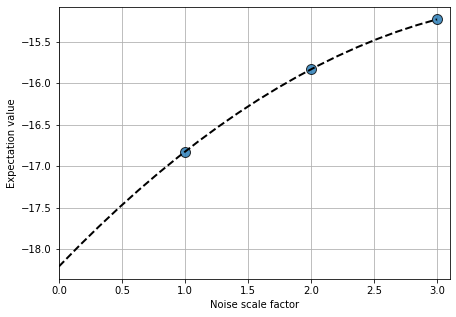

In [898]:
_ = factory3.plot_fit()